In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("mps")
import datasets
import transformers

In [3]:
from transformers import AutoModel,AutoTokenizer
model_ckpt = 'distilbert-base-uncased'
model = AutoModel.from_pretrained(model_ckpt).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [4]:
train_data = datasets.load_dataset("csv",data_files="train.csv",split="train")
test_data = datasets.load_dataset("csv",data_files="test.csv",split="train")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
train_data

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target'],
    num_rows: 7613
})

In [6]:
test_data

Dataset({
    features: ['id', 'keyword', 'location', 'text'],
    num_rows: 3263
})

In [7]:
#apply tokenizer
def tokenize(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)

In [9]:
train_data_en = train_data.map(tokenize,batched=True,batch_size=None)
test_data_en = test_data.map(tokenize,batched=True,batch_size=None)

Map:   0%|          | 0/7613 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [10]:
train_data_en.set_format(type='torch',columns=['input_ids','attention_mask','target'])
test_data_en.set_format(type='torch',columns=['input_ids','attention_mask'])

In [11]:
train_data_en[0]

{'target': tensor(1),
 'input_ids': tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  1001,  8372,
          2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
#extract hidden state 
def extract_hidden(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        out = model(**inputs)
    hidden = out.last_hidden_state[:,0]
    return {"hidden":hidden.cpu().numpy()}

In [14]:
train_hidden = train_data_en.map(extract_hidden,batched=True,batch_size=16)
test_hidden = test_data_en.map(extract_hidden,batched=True,batch_size=16)

Map:   0%|          | 0/7613 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [17]:
import numpy as np
X_train = np.array(train_hidden['hidden'])
y_train = np.array(train_hidden['target'])
X_test = np.array(test_hidden['hidden'])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


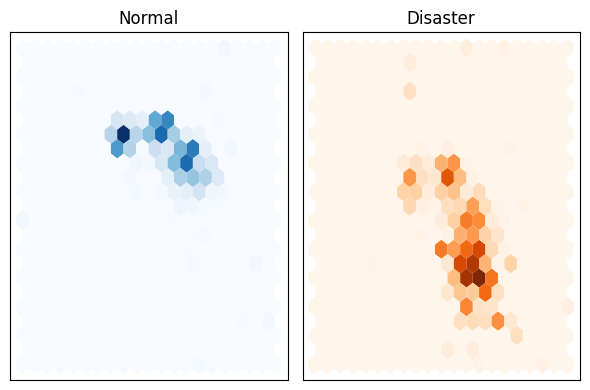

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()
X_scaled = min_max.fit_transform(X_train)
mapper = UMAP(n_components=2,metric='cosine').fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_,columns=['X','Y'])
df_emb['label'] = y_train
fig,axes = plt.subplots(1,2,figsize=(6,4))
axes = axes.flatten()
cmaps = ['Blues','Oranges']
labels = ["Normal","Disaster"]
for i,(label,cmaps) in enumerate(zip(labels,cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub['X'],df_emb_sub['Y'],cmap=cmaps,gridsize=20,linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]),axes[i].set_yticks([])
plt.tight_layout()
plt.show()

In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)

In [22]:
pred_to_csv(pred_rfc,"rfc_bert")

In [23]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(X_train,y_train)
pred_lg = lg.predict(X_test)

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
pred_to_csv(pred_lg,"LG_bert")

In [25]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
pred_xgb = xgb.predict(X_test)

In [26]:
pred_to_csv(pred_xgb,"XG_bert")

In [27]:
import torch.nn as nn
import torch.nn.functional as F
class Model(nn.Module):
    def __init__(self,in_size,h1,h2,h3,h4,h5,out_size=6):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(in_size,h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.fc2 = nn.Linear(h1,h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.fc3 = nn.Linear(h2,h3)
        self.bn3 = nn.BatchNorm1d(h3)
        self.fc4 = nn.Linear(h3,h4)
        self.bn4 = nn.BatchNorm1d(h4)
        self.fc5 = nn.Linear(h4,h5)
        self.bn5 = nn.BatchNorm1d(h5)
        self.out = nn.Linear(h5,out_size)
    def forward(self,x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = self.out(x)
        return F.log_softmax(x,dim=1)

In [28]:
model = Model(X_train.shape[1],h1=512,h2=256,h3=128,h4=64,h5=32,out_size=6).to(device)

In [30]:
X_train_pt = torch.Tensor(X_train).to(device)
y_train_pt = torch.LongTensor(y_train).to(device)
X_val_pt = torch.Tensor(X_test).to(device)

In [31]:
num_epochs = 300
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [34]:
for epoch in range(num_epochs):
    y_pred = model(X_train_pt)
    loss = criterion(y_pred,y_train_pt)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1)%50==0:
        print(f"epoch : {epoch+1} loss:{loss.item()}")

epoch : 50 loss:0.3325308859348297
epoch : 100 loss:0.3014482259750366
epoch : 150 loss:0.2725652754306793
epoch : 200 loss:0.24757181107997894
epoch : 250 loss:0.2251119166612625
epoch : 300 loss:0.20534276962280273


In [35]:
with torch.no_grad():
    y_val_model = torch.argmax(model(X_val_pt),dim=1)
y_val_model = y_val_model.cpu().numpy()

In [ ]:
pred_to_csv(pred_xgb,"XG_bert")